In [2]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from pandas import DataFrame
import dask.dataframe as dd
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
import shap
import time
import numpy as np
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

Below is the dataframe for the pathogenic coding region:

In [10]:
pathogenic_coding_region = pd.read_csv("pathogenic_coding_region_variants.csv")
pathogenic_coding_region.head()

/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,114,116,118,120,122,124,126,128,130,138,141,144,147,150,153,156,159,162,167,170,173,181,182,202,203,204,207,236,240,241) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,#Chrom,Pos,Ref,Alt,Type,Length,AnnoType,Consequence,ConsScore,...,BP4,BP5,BP6,BP7,cosmic70,MCAP,REVEL,regsnp_fpr,regsnp_disease,regsnp_splicing_site
0,0,1,1014143,C,T,SNV,0,CodingTranscript,STOP_GAINED,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1014143,C,T,SNV,0,Intergenic,UPSTREAM,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,1014143,C,T,SNV,0,RegulatoryFeature,REGULATORY,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,1014143,C,T,SNV,0,RegulatoryFeature,REGULATORY,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,1022225,G,A,SNV,0,CodingTranscript,NON_SYNONYMOUS,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Below we have cut out columns we will not use for our model, since they do not improve the model's learning ability:

In [11]:
pathogenic_coding_region = pathogenic_coding_region.drop(columns = ['Unnamed: 0', '#Chrom', 'Pos', 'Length', 'End', 'Type', 'AnnoType'])

We set a new column so that we can distinguish this data from the other regions:

In [12]:
pathogenic_coding_region['category'] = 'pathogenic_coding'

Below we keep only the numerical columns for PCA:

In [13]:
pathogenic_coding_region_for_pca = pathogenic_coding_region[['ConsScore', 'GC', 'CpG', 'motifECount', 'motifEHIPos', 'motifEScoreChng', 'cDNApos', 'relcDNApos', 'CDSpos', 'relCDSpos', 'protPos', 'relProtPos', 'Dst2Splice', 'minDistTSS', 'minDistTSE', 'SIFTval', 'mamPhCons', 'verPhCons', 'priPhyloP', 'mamPhyloP', 'verPhyloP', 'bStatistic', 'targetScan', 'mirSVR-Score', 'mirSVR-E', 'mirSVR-Aln', 'GerpRS', 'GerpRSpval', 'tOverlapMotifs', 'motifDist', 'EncodeH3K4me1-sum', 'EncodeH3K4me1-max', 'EncodeH3K4me2-sum', 'EncodeH3K4me2-max', 'EncodeH3K4me3-sum', 'EncodeH3K4me3-max', 'EncodeH3K9ac-sum', 'EncodeH3K9ac-max', 'EncodeH3K9me3-sum', 'EncodeH3K9me3-max', 'EncodeH3K27ac-sum', 'EncodeH3K27ac-max', 'EncodeH3K27me3-sum', 'EncodeH3K27me3-max', 'EncodeH3K36me3-sum', 'EncodeH3K36me3-max', 'EncodeH3K79me2-sum', 'EncodeH3K79me2-max', 'EncodeH4K20me1-sum', 'EncodeH4K20me1-max', 'EncodeH2AFZ-sum', 'EncodeH2AFZ-max', 'EncodeDNase-sum', 'EncodeDNase-max', 'EncodetotalRNA-sum', 'EncodetotalRNA-max', 'Grantham', 'Dist2Mutation', 'Freq100bp', 'Rare100bp', 'Sngl100bp', 'Freq1000bp', 'Rare1000bp', 'Sngl1000bp', 'Freq10000bp', 'Rare10000bp', 'Sngl10000bp', 'dbscSNV-ada_score', 'dbscSNV-rf_score', 'RemapOverlapTF', 'RemapOverlapCL', 'RawScore', 'PHRED', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score', 'LRT_score', 'MutationTaster_score', 'MutationAssessor_score', 'FATHMM_score', 'RadialSVM_score', 'LR_score', 'VEST3_score', 'CADD_raw', 'CADD_phred', 'GERP++_RS', 'phyloP46way_placental', 'phyloP100way_vertebrate', 'SiPhy_29way_logOdds', 'SIFT_score.1', 'SIFT_converted_rankscore', 'Polyphen2_HDIV_score.1', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score.1', 'Polyphen2_HVAR_rankscore', 'LRT_score.1', 'LRT_converted_rankscore', 'MutationTaster_score.1', 'MutationTaster_converted_rankscore', 'MutationAssessor_score.1', 'MutationAssessor_score_rankscore', 'FATHMM_score.1', 'FATHMM_converted_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST3_score.1', 'VEST3_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'M-CAP_score', 'M-CAP_rankscore', 'CADD_raw.1', 'CADD_raw_rankscore', 'CADD_phred.1', 'DANN_score', 'DANN_rankscore', 'fathmm-MKL_coding_score', 'fathmm-MKL_coding_rankscore', 'Eigen-raw', 'Eigen-PC-raw', 'GenoCanyon_score', 'GenoCanyon_score_rankscore', 'integrated_fitCons_score', 'integrated_fitCons_score_rankscore', 'integrated_confidence_value', 'GERP++_RS.1', 'GERP++_RS_rankscore', 'phyloP100way_vertebrate.1', 'phyloP100way_vertebrate_rankscore', 'phyloP20way_mammalian', 'phyloP20way_mammalian_rankscore', 'phastCons100way_vertebrate', 'phastCons100way_vertebrate_rankscore', 'phastCons20way_mammalian', 'phastCons20way_mammalian_rankscore', 'SiPhy_29way_logOdds.1', 'SiPhy_29way_logOdds_rankscore', 'dbscSNV_ADA_SCORE', 'dbscSNV_RF_SCORE', 'PVS1', 'PS1', 'PS2', 'PS3', 'PS4', 'PM1', 'PM2', 'PM3', 'PM4', 'PM5', 'PM6', 'PP1', 'PP2', 'PP3', 'PP4', 'PP5', 'BA1', 'BS1', 'BS2', 'BS3', 'BS4', 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'MCAP', 'REVEL', 'regsnp_fpr', 'category']]

We must fill all NaN values with 0 to use PCA. The code for this is shown below:

In [14]:
pathogenic_coding_region_for_pca_without_categorical_columns_no_nan = pathogenic_coding_region_for_pca.fillna(0)

Below I will save this dataframe for use in other Notebooks and in this Notebook if there is a memory error in the future:

In [14]:
pathogenic_coding_region_for_pca_without_categorical_columns_no_nan.to_csv('pathogenic_coding_region_for_pca.csv')

Below is the dataframe for the benign coding region:

In [15]:
benign_coding_region = pd.read_csv("benign_coding_region_variants.csv")
benign_coding_region.head()

/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,114,116,118,120,122,124,126,128,130,138,141,144,147,150,153,156,159,162,167,170,173,181,182,202,203,204,207,236,240,241) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,#Chrom,Pos,Ref,Alt,Type,Length,AnnoType,Consequence,ConsScore,...,BP4,BP5,BP6,BP7,cosmic70,MCAP,REVEL,regsnp_fpr,regsnp_disease,regsnp_splicing_site
0,0,1,1014042,G,A,SNV,0,CodingTranscript,NON_SYNONYMOUS,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,1014042,G,A,SNV,0,Intergenic,UPSTREAM,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,1,1014042,G,A,SNV,0,RegulatoryFeature,REGULATORY,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1,1014042,G,A,SNV,0,RegulatoryFeature,REGULATORY,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,1,1014217,C,T,SNV,0,CodingTranscript,SYNONYMOUS,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Again we cut out the columns not helpful to our model:

In [16]:
benign_coding_region = benign_coding_region.drop(columns = ['Unnamed: 0', '#Chrom', 'Pos', 'Length', 'End', 'Type', 'AnnoType'])

We set a new column so that we can distinguish this data from the other regions:

In [17]:
benign_coding_region['category'] = 'benign_coding'

Below we keep only the numerical columns for PCA:

In [18]:
benign_coding_region_for_pca = benign_coding_region[['ConsScore', 'GC', 'CpG', 'motifECount', 'motifEHIPos', 'motifEScoreChng', 'cDNApos', 'relcDNApos', 'CDSpos', 'relCDSpos', 'protPos', 'relProtPos', 'Dst2Splice', 'minDistTSS', 'minDistTSE', 'SIFTval', 'mamPhCons', 'verPhCons', 'priPhyloP', 'mamPhyloP', 'verPhyloP', 'bStatistic', 'targetScan', 'mirSVR-Score', 'mirSVR-E', 'mirSVR-Aln', 'GerpRS', 'GerpRSpval', 'tOverlapMotifs', 'motifDist', 'EncodeH3K4me1-sum', 'EncodeH3K4me1-max', 'EncodeH3K4me2-sum', 'EncodeH3K4me2-max', 'EncodeH3K4me3-sum', 'EncodeH3K4me3-max', 'EncodeH3K9ac-sum', 'EncodeH3K9ac-max', 'EncodeH3K9me3-sum', 'EncodeH3K9me3-max', 'EncodeH3K27ac-sum', 'EncodeH3K27ac-max', 'EncodeH3K27me3-sum', 'EncodeH3K27me3-max', 'EncodeH3K36me3-sum', 'EncodeH3K36me3-max', 'EncodeH3K79me2-sum', 'EncodeH3K79me2-max', 'EncodeH4K20me1-sum', 'EncodeH4K20me1-max', 'EncodeH2AFZ-sum', 'EncodeH2AFZ-max', 'EncodeDNase-sum', 'EncodeDNase-max', 'EncodetotalRNA-sum', 'EncodetotalRNA-max', 'Grantham', 'Dist2Mutation', 'Freq100bp', 'Rare100bp', 'Sngl100bp', 'Freq1000bp', 'Rare1000bp', 'Sngl1000bp', 'Freq10000bp', 'Rare10000bp', 'Sngl10000bp', 'dbscSNV-ada_score', 'dbscSNV-rf_score', 'RemapOverlapTF', 'RemapOverlapCL', 'RawScore', 'PHRED', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score', 'LRT_score', 'MutationTaster_score', 'MutationAssessor_score', 'FATHMM_score', 'RadialSVM_score', 'LR_score', 'VEST3_score', 'CADD_raw', 'CADD_phred', 'GERP++_RS', 'phyloP46way_placental', 'phyloP100way_vertebrate', 'SiPhy_29way_logOdds', 'SIFT_score.1', 'SIFT_converted_rankscore', 'Polyphen2_HDIV_score.1', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score.1', 'Polyphen2_HVAR_rankscore', 'LRT_score.1', 'LRT_converted_rankscore', 'MutationTaster_score.1', 'MutationTaster_converted_rankscore', 'MutationAssessor_score.1', 'MutationAssessor_score_rankscore', 'FATHMM_score.1', 'FATHMM_converted_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST3_score.1', 'VEST3_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'M-CAP_score', 'M-CAP_rankscore', 'CADD_raw.1', 'CADD_raw_rankscore', 'CADD_phred.1', 'DANN_score', 'DANN_rankscore', 'fathmm-MKL_coding_score', 'fathmm-MKL_coding_rankscore', 'Eigen-raw', 'Eigen-PC-raw', 'GenoCanyon_score', 'GenoCanyon_score_rankscore', 'integrated_fitCons_score', 'integrated_fitCons_score_rankscore', 'integrated_confidence_value', 'GERP++_RS.1', 'GERP++_RS_rankscore', 'phyloP100way_vertebrate.1', 'phyloP100way_vertebrate_rankscore', 'phyloP20way_mammalian', 'phyloP20way_mammalian_rankscore', 'phastCons100way_vertebrate', 'phastCons100way_vertebrate_rankscore', 'phastCons20way_mammalian', 'phastCons20way_mammalian_rankscore', 'SiPhy_29way_logOdds.1', 'SiPhy_29way_logOdds_rankscore', 'dbscSNV_ADA_SCORE', 'dbscSNV_RF_SCORE', 'PVS1', 'PS1', 'PS2', 'PS3', 'PS4', 'PM1', 'PM2', 'PM3', 'PM4', 'PM5', 'PM6', 'PP1', 'PP2', 'PP3', 'PP4', 'PP5', 'BA1', 'BS1', 'BS2', 'BS3', 'BS4', 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'MCAP', 'REVEL', 'regsnp_fpr', 'category']]

We must fill all NaN values with 0 to use PCA. The code for this is shown below:

In [19]:
benign_coding_region_for_pca_without_categorical_columns_no_nan = benign_coding_region_for_pca.fillna(0)

Below I will save this dataframe for use in other Notebooks and in this Notebook if there is a memory error in the future:

In [20]:
benign_coding_region_for_pca_without_categorical_columns_no_nan.to_csv('benign_coding_region_for_pca.csv')

Below is the dataframe for the pathogenic noncoding region:

In [22]:
pathogenic_noncoding_region = pd.read_csv("pathogenic_noncoding_region_variants.csv")
pd.options.display.max_rows = 8
pathogenic_noncoding_region

/opt/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,#Chrom,Pos,Ref,...,REVEL,regsnp_fpr,regsnp_disease,regsnp_splicing_site
0,0,1,7961859,C,...,NaN,NaN,NaN,NaN
1,1,1,7961859,C,...,NaN,NaN,NaN,NaN
2,2,1,9720021,G,...,NaN,NaN,NaN,NaN
3,3,1,9720021,G,...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
11254,2641,X,154419746,G,...,NaN,NaN,NaN,NaN
11255,2642,X,154419746,G,...,NaN,NaN,NaN,NaN
11256,2643,X,154420211,G,...,0.869,NaN,NaN,NaN
11257,2644,X,154420211,G,...,0.869,NaN,NaN,NaN


In [7]:
count_nan = len(pathogenic_noncoding_region) - pathogenic_noncoding_region.count()
pd.options.display.max_rows = 242
count_nan

Unnamed: 0                                  0
#Chrom                                      0
Pos                                         0
Ref                                         0
Alt                                         0
Type                                        0
Length                                      0
AnnoType                                    0
Consequence                                 0
ConsScore                                   0
ConsDetail                                  0
GC                                          0
CpG                                         0
motifECount                             10685
motifEName                              10685
motifEHIPos                             10685
motifEScoreChng                         10800
oAA                                      9019
nAA                                      9019
GeneID                                   1704
FeatureID                                   0
GeneName                          

Again we cut out the columns not helpful to our model:

In [23]:
pathogenic_noncoding_region = pathogenic_noncoding_region.drop(columns =['Unnamed: 0', '#Chrom', 'Pos', 'Length', 'End', 'Type', 'AnnoType'])

We set a new column so that we can distinguish this data from the other regions:

In [24]:
pathogenic_noncoding_region['category'] = 'pathogenic_noncoding'

Below we keep only the numerical columns for PCA:

In [25]:
pathogenic_noncoding_region_for_pca = pathogenic_noncoding_region[['ConsScore', 'GC', 'CpG', 'motifECount', 'motifEHIPos', 'motifEScoreChng', 'cDNApos', 'relcDNApos', 'CDSpos', 'relCDSpos', 'protPos', 'relProtPos', 'Dst2Splice', 'minDistTSS', 'minDistTSE', 'SIFTval', 'mamPhCons', 'verPhCons', 'priPhyloP', 'mamPhyloP', 'verPhyloP', 'bStatistic', 'targetScan', 'mirSVR-Score', 'mirSVR-E', 'mirSVR-Aln', 'GerpRS', 'GerpRSpval', 'tOverlapMotifs', 'motifDist', 'EncodeH3K4me1-sum', 'EncodeH3K4me1-max', 'EncodeH3K4me2-sum', 'EncodeH3K4me2-max', 'EncodeH3K4me3-sum', 'EncodeH3K4me3-max', 'EncodeH3K9ac-sum', 'EncodeH3K9ac-max', 'EncodeH3K9me3-sum', 'EncodeH3K9me3-max', 'EncodeH3K27ac-sum', 'EncodeH3K27ac-max', 'EncodeH3K27me3-sum', 'EncodeH3K27me3-max', 'EncodeH3K36me3-sum', 'EncodeH3K36me3-max', 'EncodeH3K79me2-sum', 'EncodeH3K79me2-max', 'EncodeH4K20me1-sum', 'EncodeH4K20me1-max', 'EncodeH2AFZ-sum', 'EncodeH2AFZ-max', 'EncodeDNase-sum', 'EncodeDNase-max', 'EncodetotalRNA-sum', 'EncodetotalRNA-max', 'Grantham', 'Dist2Mutation', 'Freq100bp', 'Rare100bp', 'Sngl100bp', 'Freq1000bp', 'Rare1000bp', 'Sngl1000bp', 'Freq10000bp', 'Rare10000bp', 'Sngl10000bp', 'dbscSNV-ada_score', 'dbscSNV-rf_score', 'RemapOverlapTF', 'RemapOverlapCL', 'RawScore', 'PHRED', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score', 'LRT_score', 'MutationTaster_score', 'MutationAssessor_score', 'FATHMM_score', 'RadialSVM_score', 'LR_score', 'VEST3_score', 'CADD_raw', 'CADD_phred', 'GERP++_RS', 'phyloP46way_placental', 'phyloP100way_vertebrate', 'SiPhy_29way_logOdds', 'SIFT_score.1', 'SIFT_converted_rankscore', 'Polyphen2_HDIV_score.1', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score.1', 'Polyphen2_HVAR_rankscore', 'LRT_score.1', 'LRT_converted_rankscore', 'MutationTaster_score.1', 'MutationTaster_converted_rankscore', 'MutationAssessor_score.1', 'MutationAssessor_score_rankscore', 'FATHMM_score.1', 'FATHMM_converted_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST3_score.1', 'VEST3_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'M-CAP_score', 'M-CAP_rankscore', 'CADD_raw.1', 'CADD_raw_rankscore', 'CADD_phred.1', 'DANN_score', 'DANN_rankscore', 'fathmm-MKL_coding_score', 'fathmm-MKL_coding_rankscore', 'Eigen-raw', 'Eigen-PC-raw', 'GenoCanyon_score', 'GenoCanyon_score_rankscore', 'integrated_fitCons_score', 'integrated_fitCons_score_rankscore', 'integrated_confidence_value', 'GERP++_RS.1', 'GERP++_RS_rankscore', 'phyloP100way_vertebrate.1', 'phyloP100way_vertebrate_rankscore', 'phyloP20way_mammalian', 'phyloP20way_mammalian_rankscore', 'phastCons100way_vertebrate', 'phastCons100way_vertebrate_rankscore', 'phastCons20way_mammalian', 'phastCons20way_mammalian_rankscore', 'SiPhy_29way_logOdds.1', 'SiPhy_29way_logOdds_rankscore', 'dbscSNV_ADA_SCORE', 'dbscSNV_RF_SCORE', 'PVS1', 'PS1', 'PS2', 'PS3', 'PS4', 'PM1', 'PM2', 'PM3', 'PM4', 'PM5', 'PM6', 'PP1', 'PP2', 'PP3', 'PP4', 'PP5', 'BA1', 'BS1', 'BS2', 'BS3', 'BS4', 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'MCAP', 'REVEL', 'regsnp_fpr', 'category']]

We must fill all NaN values with 0 to use PCA. The code for this is shown below:

In [26]:
pathogenic_noncoding_region_for_pca_without_categorical_columns_no_nan = pathogenic_noncoding_region_for_pca.fillna(0)

Below I will save this dataframe for use in other Notebooks and in this Notebook if there is a memory error in the future:

In [27]:
pathogenic_noncoding_region_for_pca_without_categorical_columns_no_nan.to_csv('pathogenic_noncoding_region_for_pca.csv')

Below is the dataframe for the benign noncoding region:

In [2]:
benign_noncoding_final_dataframe_with_nan_and_floats = dd.read_csv('benign_noncoding_final_dataframe_with_nan_and_floats.csv', dtype={'AAChange.ensGene': 'object',
       'AAChange.knownGene': 'object',
       'AAChange.refGene': 'object',
       'Domain': 'object',
       'Eigen_coding_or_noncoding': 'object',
       'Exon': 'object',
       'ExonicFunc.ensGene': 'object',
       'ExonicFunc.knownGene': 'object',
       'ExonicFunc.refGene': 'object',
       'FATHMM_pred': 'object',
       'FATHMM_pred.1': 'object',
       'InterVar_automated': 'object',
       'Interpro_domain': 'object',
       'Interpro_domain.1': 'object',
       'LRT_pred': 'object',
       'LRT_pred.1': 'object',
       'LR_pred': 'object',
       'M-CAP_pred': 'object',
       'MetaLR_pred': 'object',
       'MetaSVM_pred': 'object',
       'MutationAssessor_pred': 'object',
       'MutationAssessor_pred.1': 'object',
       'MutationTaster_pred': 'object',
       'MutationTaster_pred.1': 'object',
       'PROVEAN_pred': 'object',
       'PolyPhenCat': 'object',
       'Polyphen2_HDIV_pred': 'object',
       'Polyphen2_HDIV_pred.1': 'object',
       'Polyphen2_HVAR_pred': 'object',
       'Polyphen2_HVAR_pred.1': 'object',
       'RadialSVM_pred': 'object',
       'SIFT_pred': 'object',
       'SIFT_pred.1': 'object',
       'SIFTcat': 'object',
       'cosmic70': 'object',
       'fathmm-MKL_coding_pred': 'object',
       'nAA': 'object',
       'oAA': 'object', 
        'GTEx_V6_gene': 'object',
       'GTEx_V6_tissue': 'object', '#Chrom': 'object'}).compute()

/opt/miniconda3/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (93) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
/opt/miniconda3/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
/opt/miniconda3/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (93,94,95,217,233,235) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
/opt/miniconda3/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (93,94,233,235) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
/opt/miniconda3/lib/python3.7/site-packages/dask/local.py:252: DtypeWarning: Columns (35,93,94,95,217,233,235

Again we cut out the columns not helpful to our model:

In [3]:
benign_noncoding_final_dataframe_with_nan_and_floats = benign_noncoding_final_dataframe_with_nan_and_floats.drop(['#Chrom', 'Pos', 'Length', 'End', 'Type', 'AnnoType'], axis = 1)

We set a new column so that we can distinguish this data from the other regions:

In [4]:
benign_noncoding_final_dataframe_with_nan_and_floats['category'] = 'benign_noncoding'

Below we keep only the columns which have numerical values:

In [5]:
benign_noncoding_region_for_pca = benign_noncoding_final_dataframe_with_nan_and_floats[['ConsScore', 'GC', 'CpG', 'motifECount', 'motifEHIPos', 'motifEScoreChng', 'cDNApos', 'relcDNApos', 'CDSpos', 'relCDSpos', 'protPos', 'relProtPos', 'Dst2Splice', 'minDistTSS', 'minDistTSE', 'SIFTval', 'mamPhCons', 'verPhCons', 'priPhyloP', 'mamPhyloP', 'verPhyloP', 'bStatistic', 'targetScan', 'mirSVR-Score', 'mirSVR-E', 'mirSVR-Aln', 'GerpRS', 'GerpRSpval', 'tOverlapMotifs', 'motifDist', 'EncodeH3K4me1-sum', 'EncodeH3K4me1-max', 'EncodeH3K4me2-sum', 'EncodeH3K4me2-max', 'EncodeH3K4me3-sum', 'EncodeH3K4me3-max', 'EncodeH3K9ac-sum', 'EncodeH3K9ac-max', 'EncodeH3K9me3-sum', 'EncodeH3K9me3-max', 'EncodeH3K27ac-sum', 'EncodeH3K27ac-max', 'EncodeH3K27me3-sum', 'EncodeH3K27me3-max', 'EncodeH3K36me3-sum', 'EncodeH3K36me3-max', 'EncodeH3K79me2-sum', 'EncodeH3K79me2-max', 'EncodeH4K20me1-sum', 'EncodeH4K20me1-max', 'EncodeH2AFZ-sum', 'EncodeH2AFZ-max', 'EncodeDNase-sum', 'EncodeDNase-max', 'EncodetotalRNA-sum', 'EncodetotalRNA-max', 'Grantham', 'Dist2Mutation', 'Freq100bp', 'Rare100bp', 'Sngl100bp', 'Freq1000bp', 'Rare1000bp', 'Sngl1000bp', 'Freq10000bp', 'Rare10000bp', 'Sngl10000bp', 'dbscSNV-ada_score', 'dbscSNV-rf_score', 'RemapOverlapTF', 'RemapOverlapCL', 'RawScore', 'PHRED', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score', 'LRT_score', 'MutationTaster_score', 'MutationAssessor_score', 'FATHMM_score', 'RadialSVM_score', 'LR_score', 'VEST3_score', 'CADD_raw', 'CADD_phred', 'GERP++_RS', 'phyloP46way_placental', 'phyloP100way_vertebrate', 'SiPhy_29way_logOdds', 'SIFT_score.1', 'SIFT_converted_rankscore', 'Polyphen2_HDIV_score.1', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score.1', 'Polyphen2_HVAR_rankscore', 'LRT_score.1', 'LRT_converted_rankscore', 'MutationTaster_score.1', 'MutationTaster_converted_rankscore', 'MutationAssessor_score.1', 'MutationAssessor_score_rankscore', 'FATHMM_score.1', 'FATHMM_converted_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST3_score.1', 'VEST3_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'M-CAP_score', 'M-CAP_rankscore', 'CADD_raw.1', 'CADD_raw_rankscore', 'CADD_phred.1', 'DANN_score', 'DANN_rankscore', 'fathmm-MKL_coding_score', 'fathmm-MKL_coding_rankscore', 'Eigen-raw', 'Eigen-PC-raw', 'GenoCanyon_score', 'GenoCanyon_score_rankscore', 'integrated_fitCons_score', 'integrated_fitCons_score_rankscore', 'integrated_confidence_value', 'GERP++_RS.1', 'GERP++_RS_rankscore', 'phyloP100way_vertebrate.1', 'phyloP100way_vertebrate_rankscore', 'phyloP20way_mammalian', 'phyloP20way_mammalian_rankscore', 'phastCons100way_vertebrate', 'phastCons100way_vertebrate_rankscore', 'phastCons20way_mammalian', 'phastCons20way_mammalian_rankscore', 'SiPhy_29way_logOdds.1', 'SiPhy_29way_logOdds_rankscore', 'dbscSNV_ADA_SCORE', 'dbscSNV_RF_SCORE', 'PVS1', 'PS1', 'PS2', 'PS3', 'PS4', 'PM1', 'PM2', 'PM3', 'PM4', 'PM5', 'PM6', 'PP1', 'PP2', 'PP3', 'PP4', 'PP5', 'BA1', 'BS1', 'BS2', 'BS3', 'BS4', 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'MCAP', 'REVEL', 'regsnp_fpr', 'category']]

Now we change the NaN values with 0 so that we can run PCA:

In [6]:
benign_noncoding_region_for_pca_without_categorical_columns_no_nan = benign_noncoding_region_for_pca.fillna(0)

Again we save the above dataframe for future use. However, this is in the form of a Dask Dataframe so I will need to be careful with using it in the future:

In [7]:
benign_noncoding_region_for_pca_without_categorical_columns_no_nan.to_csv('benign_noncoding_region_for_pca.csv')

Below we combine all the dataframes into one. This will allow us to see the differences between the annotation scores of the separate regions, if there are any. We have to append the dataframes one by one using 32 GB of RAM since the files are so large. Also, we keep only the columns that have numerical values in them:

In [12]:
df_for_pca_1 = dd.read_csv('benign_noncoding_region_for_pca.csv', dtype={'AAChange.ensGene': 'object',
       'AAChange.knownGene': 'object',
       'AAChange.refGene': 'object',
       'Domain': 'object',
       'Eigen_coding_or_noncoding': 'object',
       'Exon': 'object',
       'ExonicFunc.ensGene': 'object',
       'ExonicFunc.knownGene': 'object',
       'ExonicFunc.refGene': 'object',
       'FATHMM_pred': 'object',
       'FATHMM_pred.1': 'object',
       'InterVar_automated': 'object',
       'Interpro_domain': 'object',
       'Interpro_domain.1': 'object',
       'LRT_pred': 'object',
       'LRT_pred.1': 'object',
       'LR_pred': 'object',
       'M-CAP_pred': 'object',
       'MetaLR_pred': 'object',
       'MetaSVM_pred': 'object',
       'MutationAssessor_pred': 'object',
       'MutationAssessor_pred.1': 'object',
       'MutationTaster_pred': 'object',
       'MutationTaster_pred.1': 'object',
       'PROVEAN_pred': 'object',
       'PolyPhenCat': 'object',
       'Polyphen2_HDIV_pred': 'object',
       'Polyphen2_HDIV_pred.1': 'object',
       'Polyphen2_HVAR_pred': 'object',
       'Polyphen2_HVAR_pred.1': 'object',
       'RadialSVM_pred': 'object',
       'SIFT_pred': 'object',
       'SIFT_pred.1': 'object',
       'SIFTcat': 'object',
       'cosmic70': 'object',
       'fathmm-MKL_coding_pred': 'object',
       'nAA': 'object',
       'oAA': 'object', 
        'GTEx_V6_gene': 'object',
       'GTEx_V6_tissue': 'object', '#Chrom': 'object'}).compute().append(pd.read_csv('pathogenic_noncoding_region_for_pca.csv'), ignore_index = True)
df_for_pca_1.drop(columns = ['Unnamed: 0'])

,ConsScore,GC,CpG,...,REVEL,regsnp_fpr,category
0,4,0.649,0.027,...,0.000,0.0,benign_noncoding
1,2,0.649,0.027,...,0.000,0.0,benign_noncoding
2,4,0.596,0.027,...,0.000,0.0,benign_noncoding
3,2,0.596,0.027,...,0.000,0.0,benign_noncoding
...,...,...,...,...,...,...,...
1550203,8,0.636,0.067,...,0.000,0.0,pathogenic_noncoding
1550204,1,0.636,0.067,...,0.000,0.0,pathogenic_noncoding
1550205,1,0.636,0.053,...,0.869,0.0,pathogenic_noncoding
1550206,6,0.636,0.053,...,0.869,0.0,pathogenic_noncoding


In [13]:
df_for_pca_2 = df_for_pca_1.append(pd.read_csv('pathogenic_coding_region_for_pca.csv'), ignore_index = True)
df_for_pca_2.drop(columns = ['Unnamed: 0'])

,ConsScore,GC,CpG,...,REVEL,regsnp_fpr,category
0,4.0,0.649,0.027,...,0.000,0.0,benign_noncoding
1,2.0,0.649,0.027,...,0.000,0.0,benign_noncoding
2,4.0,0.596,0.027,...,0.000,0.0,benign_noncoding
3,2.0,0.596,0.027,...,0.000,0.0,benign_noncoding
...,...,...,...,...,...,...,...
1670496,7.0,0.424,0.013,...,0.222,0.0,pathogenic_coding
1670497,4.0,0.424,0.013,...,0.222,0.0,pathogenic_coding
1670498,7.0,0.375,0.000,...,0.000,0.0,pathogenic_coding
1670499,2.0,0.375,0.000,...,0.000,0.0,pathogenic_coding


In [14]:
df_for_pca_final = df_for_pca_2.append(pd.read_csv('benign_coding_region_for_pca.csv'), ignore_index = True)
df_for_pca_final.drop(columns = ['Unnamed: 0'])

,ConsScore,GC,CpG,...,REVEL,regsnp_fpr,category
0,4.0,0.649,0.027,...,0.0,0.0,benign_noncoding
1,2.0,0.649,0.027,...,0.0,0.0,benign_noncoding
2,4.0,0.596,0.027,...,0.0,0.0,benign_noncoding
3,2.0,0.596,0.027,...,0.0,0.0,benign_noncoding
...,...,...,...,...,...,...,...
1801867,2.0,0.377,0.013,...,0.0,0.0,benign_coding
1801868,4.0,0.695,0.147,...,0.0,0.0,benign_coding
1801869,2.0,0.695,0.147,...,0.0,0.0,benign_coding
1801870,1.0,0.695,0.147,...,0.0,0.0,benign_coding


In [15]:
df_for_pca_final.to_csv('all_variants_for_pca.csv')

Below we import the final dataframe above to be used for PCA:

In [3]:
df_for_pca_final = pd.read_csv('all_variants_for_pca.csv', dtype = {'category' : 'object'}, low_memory = False)

We can now run PCA on the data and visualize it using the code below:

In [4]:
from sklearn.preprocessing import StandardScaler
features = ['ConsScore', 'GC', 'CpG', 'motifECount', 'motifEHIPos', 'motifEScoreChng', 'cDNApos', 'relcDNApos', 'CDSpos', 'relCDSpos', 'protPos', 'relProtPos', 'Dst2Splice', 'minDistTSS', 'minDistTSE', 'SIFTval', 'mamPhCons', 'verPhCons', 'priPhyloP', 'mamPhyloP', 'verPhyloP', 'bStatistic', 'targetScan', 'mirSVR-Score', 'mirSVR-E', 'mirSVR-Aln', 'GerpRS', 'GerpRSpval', 'tOverlapMotifs', 'motifDist', 'EncodeH3K4me1-sum', 'EncodeH3K4me1-max', 'EncodeH3K4me2-sum', 'EncodeH3K4me2-max', 'EncodeH3K4me3-sum', 'EncodeH3K4me3-max', 'EncodeH3K9ac-sum', 'EncodeH3K9ac-max', 'EncodeH3K9me3-sum', 'EncodeH3K9me3-max', 'EncodeH3K27ac-sum', 'EncodeH3K27ac-max', 'EncodeH3K27me3-sum', 'EncodeH3K27me3-max', 'EncodeH3K36me3-sum', 'EncodeH3K36me3-max', 'EncodeH3K79me2-sum', 'EncodeH3K79me2-max', 'EncodeH4K20me1-sum', 'EncodeH4K20me1-max', 'EncodeH2AFZ-sum', 'EncodeH2AFZ-max', 'EncodeDNase-sum', 'EncodeDNase-max', 'EncodetotalRNA-sum', 'EncodetotalRNA-max', 'Grantham', 'Dist2Mutation', 'Freq100bp', 'Rare100bp', 'Sngl100bp', 'Freq1000bp', 'Rare1000bp', 'Sngl1000bp', 'Freq10000bp', 'Rare10000bp', 'Sngl10000bp', 'dbscSNV-ada_score', 'dbscSNV-rf_score', 'RemapOverlapTF', 'RemapOverlapCL', 'RawScore', 'PHRED', 'SIFT_score', 'Polyphen2_HDIV_score', 'Polyphen2_HVAR_score', 'LRT_score', 'MutationTaster_score', 'MutationAssessor_score', 'FATHMM_score', 'RadialSVM_score', 'LR_score', 'VEST3_score', 'CADD_raw', 'CADD_phred', 'GERP++_RS', 'phyloP46way_placental', 'phyloP100way_vertebrate', 'SiPhy_29way_logOdds', 'SIFT_score.1', 'SIFT_converted_rankscore', 'Polyphen2_HDIV_score.1', 'Polyphen2_HDIV_rankscore', 'Polyphen2_HVAR_score.1', 'Polyphen2_HVAR_rankscore', 'LRT_score.1', 'LRT_converted_rankscore', 'MutationTaster_score.1', 'MutationTaster_converted_rankscore', 'MutationAssessor_score.1', 'MutationAssessor_score_rankscore', 'FATHMM_score.1', 'FATHMM_converted_rankscore', 'PROVEAN_score', 'PROVEAN_converted_rankscore', 'VEST3_score.1', 'VEST3_rankscore', 'MetaSVM_score', 'MetaSVM_rankscore', 'MetaLR_score', 'MetaLR_rankscore', 'M-CAP_score', 'M-CAP_rankscore', 'CADD_raw.1', 'CADD_raw_rankscore', 'CADD_phred.1', 'DANN_score', 'DANN_rankscore', 'fathmm-MKL_coding_score', 'fathmm-MKL_coding_rankscore', 'Eigen-raw', 'Eigen-PC-raw', 'GenoCanyon_score', 'GenoCanyon_score_rankscore', 'integrated_fitCons_score', 'integrated_fitCons_score_rankscore', 'integrated_confidence_value', 'GERP++_RS.1', 'GERP++_RS_rankscore', 'phyloP100way_vertebrate.1', 'phyloP100way_vertebrate_rankscore', 'phyloP20way_mammalian', 'phyloP20way_mammalian_rankscore', 'phastCons100way_vertebrate', 'phastCons100way_vertebrate_rankscore', 'phastCons20way_mammalian', 'phastCons20way_mammalian_rankscore', 'SiPhy_29way_logOdds.1', 'SiPhy_29way_logOdds_rankscore', 'dbscSNV_ADA_SCORE', 'dbscSNV_RF_SCORE', 'PVS1', 'PS1', 'PS2', 'PS3', 'PS4', 'PM1', 'PM2', 'PM3', 'PM4', 'PM5', 'PM6', 'PP1', 'PP2', 'PP3', 'PP4', 'PP5', 'BA1', 'BS1', 'BS2', 'BS3', 'BS4', 'BP1', 'BP2', 'BP3', 'BP4', 'BP5', 'BP6', 'BP7', 'MCAP', 'REVEL', 'regsnp_fpr']
x = df_for_pca_final.loc[:, features].values
x = StandardScaler().fit_transform(x)
y = df_for_pca_final.loc[:,['category']].values

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

In [6]:
pd.options.display.max_rows = 8
finalDf = pd.concat([principalDf, df_for_pca_final[['category']]], axis = 1, ignore_index = False)
finalDf

,principal component 1,principal component 2,category
0,-0.999324,1.253630,benign_noncoding
1,-1.041820,1.161105,benign_noncoding
2,-0.867128,0.379275,benign_noncoding
3,-0.909625,0.286750,benign_noncoding
...,...,...,...
1801867,-0.535726,-1.160219,benign_coding
1801868,-0.150857,17.254349,benign_coding
1801869,-0.193353,17.161824,benign_coding
1801870,-0.214601,17.115561,benign_coding


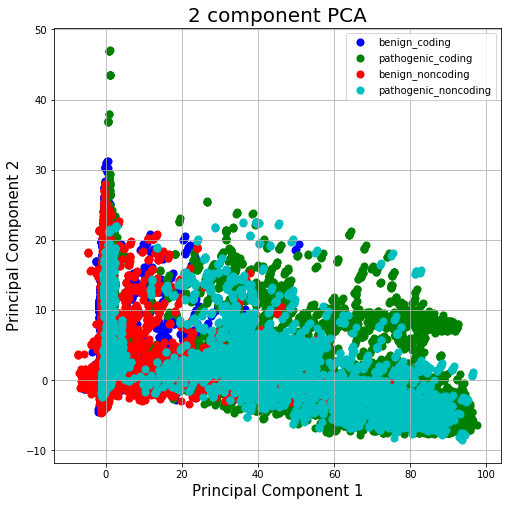

In [8]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['benign_coding', 'pathogenic_coding', 'benign_noncoding', 'pathogenic_noncoding']
colors = ['b', 'g', 'r', 'c']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['category'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1'], finalDf.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)
ax.legend(targets)
ax.grid()

The graph above shows that our data are grouped together very tightly